# Restricted Boltzmann Machine - MNIST

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from sklearn.datasets import fetch_openml
from IPython.display import HTML

In [3]:
class LOGlike(object):
    """
    FORMAT:
    D = 784      # visible
    L = 12       # hidden
    M = len(x)   # number of data points
    a = np.random.uniform(-1, 1, D)
    b = np.random.uniform(-1, 1, L)
    x = np.random.randint(0, 2, (M, D))
    z = np.random.randint(0, 2, L)
    w = np.random.uniform(-1, 1, (D, L))
    """

    def __init__(self, x, L, spins = False):
        self.a = None # a   # visible
        self.b = None # b   # hidden
        self.D = None # a.shape[0]
        self.L = None # b.shape[0]
        self.x = x
        self.spins = spins
        self.M = len(x)
        self.w = None # w
        self.q = None
        self.k = None
        self.esit = []
        self.esit_ix = []
        self.z = None
        #
    #####
    #
    def initialization(self, a, b, w):
        self.a = a   # visible
        self.b = b   # hidden
        self.D = a.shape[0]
        self.L = b.shape[0]
        self.w = w
        self.make_z_states()
        self.H_and_G()
        #
    #####
    #
    def H_and_G(self):
        
        self.H_z_matrix = np.array([self.H(z) for z in self.z])  # Shape (2^L, D)
        self.G_z_vector = np.array([self.G(z) for z in self.z])  # Shape (2^L,)
        tmp             = self.H_z_matrix @ self.x.T
        self.k          = np.mean(tmp)
        #
    #####
    #
    def make_z_states(self):
        """
        2^L config
        """
        
        def get_bin(i, L):
            b = bin(i)[2:]
            return ("0" * (L - len(b))) + b
            #
        #####
        #
        self.z = np.array([[int(bit) for bit in get_bin(i, self.L)]
                                       for i in range(2 ** self.L)])
        if self.spins:
            self.z[self.z == 0] = -1
            #
        #####
        #
    #####
    #
    def H(self, z):
        """
        H(z) = a + w @ z
        """
        
        return self.a + np.dot(self.w, z)
        #
    #####
    #
    def G(self, z):
        """
        G(z) = exp(b @ z).
        """
        
        return np.exp(np.dot(self.b, z))
        #
    #####
    #
    def get_logsumexp(self, exps):
        max   = exps.max()
        exps  = exps[exps >= (max - 50)]
        min   = exps.min()
        exps -= min
        esit  = min + np.log(np.exp(exps).sum())
        return esit
        #
    #####
    #
    def get_numerator(self, x):
        """
        ln{sum_z[G(z) * exp[dot(H_i(z) * x_i)]]}
        """

        # return scipy.special.logsumexp(self.H_z_matrix @ x)
        exps      = np.log(self.G_z_vector) + (self.H_z_matrix @ x)  # Shape (2^L,)
        return self.get_logsumexp(exps)
        # numerator = np.sum(self.G_z_vector * exp_H_x)
        # return k + np.log(numerator)
        #
    #####
    #
    def get_denominator(self):
        """
        ln(Z) = D * ln(q) + ln{sum_z[G(z) * prod_i[(1 + H_i(z)) / q]]}
        """

        # q average over 1+exp(H_i(z))
        self.q = 1 + np.exp(np.mean(self.H_z_matrix))

        # sum_Z
        prod_H_q = np.prod((1 + np.exp(self.H_z_matrix)) / self.q, axis = 1)  # Shape (2^L,)
        Z_value  = np.sum(self.G_z_vector * prod_H_q)

        return self.D * np.log(self.q) + np.log(Z_value)
        #
    #####
    #
    def get_denominator_spin(self):
        """
        ln(Z) = D * ln(q) + ln{sum_z[G(z) * prod_i[cosh(H_i(z)) / q]]}
        """
        
        #return scipy.special.logsumexp()
        # q average over cosh(H_i(z))
        #self.q = np.cosh(np.mean(self.H_z_matrix))
        #
        # sum_Z
        #prod_H_q = np.prod(2 * np.cosh(self.H_z_matrix) / self.q, axis = 1)  # Shape (2^L,)
        #Z_value  = np.sum(self.G_z_vector * prod_H_q)
        #
        #return self.D * np.log(self.q) + np.log(Z_value)    
        #
        approx = 100
        max    = self.H_z_matrix.max()
        shift  = max + approx
        exps   = np.log(self.G_z_vector) + (abs(self.H_z_matrix - shift)).sum(axis = 1)
        esit   = self.get_logsumexp(exps)
        return self.D * shift + esit
        #
    #####
    #
    def run(self):
        """
        l_θ(x) = ln{sum_z[G(z) * exp(H_i(z) * x_i)]} - ln{Z}
        """
        if (self.spins == False):
            lnZ = self.get_denominator()
        else:
            lnZ = self.get_denominator_spin()
            #
        #####
        #
        log_likelihoods = np.array([self.get_numerator(x) - lnZ for x in self.x])
        self.esit.append(np.mean(log_likelihoods))
        #
    #####
    #
    def save(self):
        print(self.esit)
        '''file = open("L/" + str(self.L) + ".txt", "tw")
        file.write(str(self.esit))
        file.close()'''
        #
    #####
    #
#####

In [4]:
class RBM:
    def __init__(self, x, L, spins=False, potts=False):
        """
        - x: dataset
        - L: number of hidden units
        - spins: if True sets x_min=-1, else x_min=0
        """
        
        if potts and spins: raise ValueError("Potts and Spins cannot coexist.")
        
        self.x_min = -1 if spins else 0
        self.x_max = 1
        self.x = binarize_data(x, self.x_min, self.x_max)
        self.data_size = len(self.x)
        self.spins = spins
        self.potts = potts
        
        self.D = self.x.shape[1]
        self.L = L
        
        self.params = {
            "w": None,
            "a": None, 
            "b": None
        }
        self.params_history = {
            "w": [], 
            "a": [], 
            "b": []
        }
        
        self.log_likelihood = LOGlike(self.x, self.L, spins=spins)

    def hinton_bias_init(self):
        xmean = np.mean(self.x, axis=0)

        # avoid divergence in log
        delta = 1e-4
        xmean = np.clip(xmean, self.x_min + delta, self.x_max - delta)

        return np.clip(np.log(xmean-self.x_min) - np.log(self.x_max-xmean), -300, 300) 
    
    def initialize_params(self):
        self.params = {
            "w": np.sqrt(4/(self.L + self.D)) * np.random.randn(self.D, self.L),
            "a": self.hinton_bias_init(),
            "b": np.zeros(self.L)
        }
        
        self.params_history = {param: [self.params[param].copy()] for param in self.params.keys()}
    
    def contrastive_divergence(self, vector_input, weights, biases, POTTS=False):
        H = np.clip( np.dot(vector_input, weights) + biases, -300, 300 )
        a = np.exp( (self.x_max - self.x_min) * H )

        output_size = H.shape
        vector_output = np.full(output_size, self.x_min)
        
        if POTTS:
            p = a / np.sum(a) # state probability
            F = np.cumsum(p) # cumulative probability
            r = np.random.rand()
            i = 0
            while r > F[i]:
                i += 1
            vector_output[i] = 1
            
        else:
            p = a / (a + 1) # local probability
            vector_output[np.random.random(output_size) < p] = self.x_max
        
        return vector_output

    def plot_weights_bias(self, weights, biases, cols=0, s=1.5, cmap="bwr", vmin=-4, vmax=4):
        """TODO: upgrade"""
        rows = int(np.ceil( self.L / cols))
        plt.clf()
        fig, axes = plt.subplots(rows, cols, figsize=(s*(1+cols), s*rows))
        for i in range(rows):
            for j in range(cols):
                if cols == 1:
                    ax = axes[i]
                else:
                    ax = axes[i,j]
                if i == j == 0:
                    ax.imshow(biases.reshape((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
                    ax.set_title("bias")
                else:
                    ax.imshow(weights.T[i*cols+j-1].reshape((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
                    ax.set_title(f"hidden {i*cols+j}")
                ax.set_xticks([])
                ax.set_yticks([])

        plt.subplots_adjust(hspace=.3)
        plt.show()
        plt.close()

    def training(self, optimizer="RMSprop", epochs=150, batches=20, batch_i=10, batch_f=500, 
                 lr=0.05, epsilon=1e-4, cd_steps=2, gamma=0.001, verbose=False):
        
        if optimizer == "SGD":
            lr_i, lr_f = 1., 0.25
        elif optimizer == "RMSprop":
            lr_i = lr_f = lr
            beta, epsilon = 0.9, epsilon
        else:
            raise ValueError("Optimizer should either be SGD or RMSprop.")
        
        s = {param:np.zeros_like(self.params[param]) for param in ["w", "a", "b"]}
        list_indices = np.arange(self.x.shape[0])
        
        for epoch in range(1, epochs+1):
            q = (epoch - 1) / (epochs - 1)
            batch_size = int(batch_i + (batch_f-batch_i) * q**2)
            lr = lr_i + (lr_f-lr_i) * q
            
            for _ in range(batches):
                v_data, v_model = [np.zeros(self.D) for _ in range(2)]
                h_data, h_model = [np.zeros(self.L) for _ in range(2)]
                vh_data, vh_model = [np.zeros((self.D,self.L)) for _ in range(2)]
                
                selected_indices = np.random.choice(list_indices, batch_size, replace=False)
                for i in range(batch_size):
                    # positive CD phase
                    v = self.x[selected_indices[i]]
                    h = self.contrastive_divergence(v, self.params["w"], self.params["b"], POTTS=self.potts)
                    
                    v_data += v
                    h_data += h
                    vh_data += np.outer(v, h)
                    
                    # generate fantasy data
                    hf = h.copy()
                    for _ in range(cd_steps):
                        # negative CD phase
                        vf = self.contrastive_divergence(hf, self.params["w"].T, self.params["a"])
                        # positive CD phase
                        hf = self.contrastive_divergence(vf, self.params["w"], self.params["b"], POTTS=self.potts)

                    v_model += vf
                    h_model += hf
                    vh_model += np.outer(vf, hf)
                    
                # gradient of likelihood
                data_models = {
                    "w": (vh_data,vh_model),
                    "a": (v_data,v_model),
                    "b": (h_data,h_model)
                }
                for param,(d,m) in data_models.items():            
                    grad_theta = (d - m) / batch_size
                    
                    if optimizer == "RMSprop":
                        s[param] = beta * s[param] + (1-beta) * grad_theta**2
                        new_param = lr * grad_theta / np.sqrt(epsilon + s[param])
                    else:
                        new_param = lr * grad_theta

                    self.params[param] += new_param

                    if gamma > 0:
                        self.params[param] -= (gamma * lr) * np.sign(self.params[param])
            
            # save weights and biases for every epoch
            for param in ["w", "a", "b"]:
                self.params_history[param].append(self.params[param].copy())
            
            # plot training process
            if verbose:
                print(f"Epoch: {epoch} / {epochs}", end="\r")
                
                # if epoch % 20 == 0: self.plot_weights_bias(self.params["w"], self.params["a"], cols=self.L//2)
        
        print("Training complete.")
    
    def test(self, v_test, n=200, af=1):
        v = v_test.copy()
        v_history = []
        h_history = []
        for _ in range(n):
            h = self.contrastive_divergence(v, self.params["w"], self.params["b"], POTTS=self.potts)
            v = self.contrastive_divergence(h, af*self.params["w"].T, af*self.params["a"])
            v_history.append(v)
            h_history.append(h)
        
        return v_history, h_history

    '''def likelihood_history(self, n=5):
        self.log_likelihood.esit = []
        if n == 1:
            list_ix = [-1]
        else:
            list_ix = np.linspace(0, len(self.params_history["w"])-1, n, dtype=int)
        self.log_likelihood.esit_ix = list_ix.copy()
        
        for ix in list_ix:
            self.log_likelihood.inizialization(
                self.params_history["a"][ix], self.params_history["b"][ix], self.params_history["w"][ix]
            )
            self.log_likelihood.run()'''
    
    def likelihood_history(self, npoints=5, from_last=1, step_last=1):
        if npoints == 1:
            list_ix = [-1]
        else:
            n_params = len(self.params_history["w"])

            list_ix2 = np.arange(n_params - step_last*from_last, n_params, step_last, dtype=int).tolist()
            list_ix1 = np.linspace(0, list_ix2[0], npoints-from_last+1, dtype=int).tolist()[:-1]

            list_ix = list_ix1 + list_ix2
        
        self.log_likelihood.esit_ix = list_ix.copy()

        for ix in list_ix:
            self.log_likelihood.initialization(
                self.params_history["a"][ix], self.params_history["b"][ix], self.params_history["w"][ix]
            )
            self.log_likelihood.run()

In [5]:
def binarize_data(data, x_min=0, x_max=1):
    return np.where(data/255 > 0.5, x_max, x_min)

def save_model(model, filename):
    np.savez(
        f"{filename}.npz",
        L = model.L,
        spins = model.spins,
        potts = model.potts,
        history_w = np.array(model.params_history["w"]),
        history_a = np.array(model.params_history["a"]),
        history_b = np.array(model.params_history["b"]),
        list_esit_ix = np.array(model.log_likelihood.esit_ix),
        list_esit = np.array(model.log_likelihood.esit)
    )

def load_model(file_path):
    data = np.load(f"{file_path}.npz", allow_pickle=True)
    model = RBM(np.array([[],]), data["L"])
    model.spins = data["spins"]
    model.potts = data["potts"]
    model.params_history = {
            "w": data["history_w"], 
            "a": data["history_a"], 
            "b": data["history_b"]
        }
    model.params = {
            "w": model.params_history["w"][-1],
            "a": model.params_history["a"][-1], 
            "b": model.params_history["b"][-1]
        }
    model.log_likelihood.esit_ix = data["list_esit_ix"]
    model.log_likelihood.esit = data["list_esit"]
    
    return model

def plot_likelihood_evolutions(list_epochs, list_models_likelihoods, list_labels=None, grid=True, colors=[], title=""):
    colors = colors if colors else ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:pink", "tab:brown"]
    
    for i,list_likelihoods in enumerate(list_models_likelihoods):
        label = None if list_labels is None else list_labels[i]
        plt.plot(list_epochs, list_likelihoods, "o-", color=colors[i], label=label)
    
    if list_labels:
        plt.legend()
    if grid:
        plt.grid(linestyle="--", alpha=0.3)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Log-Likelihood")
    plt.show()

def plot_likelihood_means(x, y, yerr=None, color="#00957c", xlabel="Models", rate_delta=0.5, title=""):
    plt.bar(x, y, yerr=yerr, color=color, capsize=3, alpha=0.7, edgecolor="k")
    y_min, y_max = plt.ylim()
    delta = min(y) - y_min
    

    plt.grid(alpha=0.5, linestyle="--")
    plt.title(title)
    plt.ylim(y_min + rate_delta*delta, max(y) + delta)
    plt.xticks(x)
    plt.xlabel(xlabel)
    plt.ylabel("Log-likelihood")
    plt.show()

def plot_weights_bias(weights, biases, L, epoch=None, s=1.5, cmap="bwr", vmin=-4, vmax=4):
    rows = 2
    cols = int(np.ceil(L/2))

    fig, axes = plt.subplots(rows, cols + 1, figsize=(s*(1+cols), s*rows))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    if epoch is not None:
        fig.suptitle(f"Epoch {epoch}", y=1.05)
    
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows == 1:
                ax = axes[j+1]
            else:
                ax = axes[i,j+1]
            if k <= L:
                ax.imshow(weights[:,k-1].reshape((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else:
                fig.delaxes(ax)
            k += 1
            
        if i > 0: 
            fig.delaxes(axes[i,0])

    if rows == 1:
        ax = axes[0]
    else:
        ax = axes[0,0]
    im=ax.imshow(biases.reshape((28,28)), cmap="bwr", vmin=vmin,vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('bias')

    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)

    plt.show()
    plt.close()

def animate_weights_bias_evolution(weights_history, biases_history, L, interval=200, 
                                   s=1.5, cmap="bwr", vmin=-4, vmax=4):
    rows = 2
    cols = int(np.ceil(L / 2))
    epochs = len(weights_history)
    
    fig, axes = plt.subplots(rows, cols + 1, figsize=(s*(1+cols), s*rows+.5))
    plt.subplots_adjust(hspace=0.05, wspace=0.3, top=0.85)
    
    title = fig.suptitle("Epoch 0", fontsize=14, y=0.97)

    images = []
    k = 1

    for i in range(rows):
        for j in range(cols):
            if rows == 1:
                ax = axes[j+1]
            else:
                ax = axes[i,j+1]
            
            if k <= L:
                img = ax.imshow(np.zeros((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
                images.append(img)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else:
                fig.delaxes(ax)
            k += 1

        if i > 0:
            fig.delaxes(axes[i,0])

    if rows == 1:
        ax = axes[0]
    else:
        ax = axes[0,0]
    
    im = ax.imshow(np.zeros((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")

    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)

    def update(epoch):
        title.set_text(f"Epoch {epoch}")
        biases = biases_history[epoch]
        weights = weights_history[epoch]
        
        im.set_data(biases.reshape((28,28)))

        for k in range(L):
            images[k].set_data(weights[:,k].reshape((28,28)))

        return [im] + images

    ani = FuncAnimation(fig, update, frames=epochs, interval=interval, blit=False)
    plt.close(fig)
    
    return HTML(ani.to_jshtml())

In [6]:
# all handwritten numbers from 0 to 9
X, Y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

# numbers to keep
list_numbers = [str(i) for i in range(10)][:3]
index_to_keep = np.isin(Y, list_numbers)
X_keep = X[index_to_keep]
Y_keep = Y[index_to_keep]

# 1) INITIALIZATION OF BIASES

**Restricted Boltzmann Machines** (RBM) are a powerful kind of generative models designed to accomplish training processes relatively fast. In RBMs, a set of binary visible units $i$ of state $v_i$ is symmetrically connected to a set of binary hidden units $j$ of state $h_j$; the continuos weight $w_{ij}$ quantifies the strength between units $i$ and $j$. In the training process, a cyclic Gibbs sampling is performed setting the visible units given the hidden ones and vice versa, according to the following probabilities:

$$
p(h_j=1\ |\ \mathbf{v}) = \sigma(b_j + \sum_iv_iw_{ij})\ \ \ \ \ \ \ \ \ \ \ (1a)
$$
$$
p(v_i=1\ |\ \mathbf{h}) = \sigma(a_i + \sum_jh_jw_{ij})\ \ \ \ \ \ \ \ \ \ \ (1b)
$$

where $\sigma(x)=1/(1+e^{-x})$ is the logistic sigmoid function, $a_i$ is the bias of the $i$-th visible unit and $b_j$ is the bias of the $j$-th hidden unit; they act shifting the sigmoid function $\sigma(x)$. The absence of links among units of the same type simplifies the training process. Moreover, the number of iterations of $(1a)$ and $(1b)$ can be setted to $1$ if real data is used to fix $\mathbf{v}$ in the first place.

Concerning the training process of RBM, $\mathbf{v}$ is setted using real data. Weights $w_{ij}$ are initialized sampling values from a Gaussian distribution of mean $0$ and standard deviation $0.01$. Biases $b_j$ of hidden units are initialized to $0$, although using $-4$ encourages sparsity in the hidden layer, which can be useful for analysis of units activation.

Thus $\mathbf{h}$ is evaluated by $(1a)$ before passed to $(1b)$ in order to compute back $\mathbf{v}$. In such evaluation it is convenient to set $a_i$ to be $\log[p_i/(1-p_i)]$; fixed the $i$-th visible unit, $p_i$ is defined as the number of times such unit is on over the whole training array set, normalized over the size of the set. Referring to $(1b)$, the choice of shifting the sigmoid $\sigma(x)$ by the function $a_i=\log[p_i/(1-p_i)]$ of the average $p_i$ ensures that the units can activate properly, even given initial weights $w_{ij}$ close to $0$.

The initialization of biases $a_i$, firstly proposed by Hinton, makes hidden units able to activate and differentiate better their activation based on data, avoiding the risk of getting stuck on values near to $0$.

# 2) LOG-LIKELIHOOD
## 2.1) Does the Log-Likelihood grow?

In [10]:
N = 5
n_last_likelihoods = 6
steps = 6

In [11]:
'''for n in range(N):
    print(f"Run {n+1} (of {N}):")
    rbm = RBM(X_keep, 10)
    rbm.initialize_params()
    rbm.training(epochs=150, optimizer="RMSprop", epsilon=1e-8, gamma=1e-4, verbose=True)
    rbm.likelihood_history(12, n_last_likelihoods, steps)
    save_model(rbm, f"DATA/10L_150e_RMS_same_model_{n+1}")'''

'for n in range(N):\n    print(f"Run {n+1} (of {N}):")\n    rbm = RBM(X_keep, 10)\n    rbm.initialize_params()\n    rbm.training(epochs=150, optimizer="RMSprop", epsilon=1e-8, gamma=1e-4, verbose=True)\n    rbm.likelihood_history(12, n_last_likelihoods, steps)\n    save_model(rbm, f"DATA/10L_150e_RMS_same_model_{n+1}")'

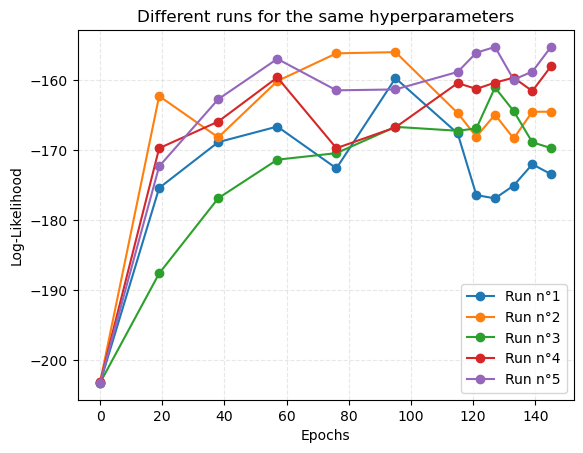

In [12]:
list_models = [load_model(f"DATA/10L_150e_RMS_same_model_{n+1}") for n in range(N)]
list_e = list_models[0].log_likelihood.esit_ix
list_l = [model.log_likelihood.esit for model in list_models]

labels = [f"Run n°{i+1}" for i in range(len(list_models))]
cmap = cm.RdPu
colors = [cmap(i) for i in np.linspace(0.2,0.8,len(list_models))]

plot_likelihood_evolutions(list_e, list_l, list_labels=labels, title="Different runs for the same hyperparameters")

The figure shows the evolution of the log-likelihood during five training attempts for the same set of hyperparameters. In all five runs, though with some stochasticity, the log-likelihood grows during training confirming that the RBM is learning. After around 100 epochs we notice that the learning phase of all the different runs tends to stabilize.

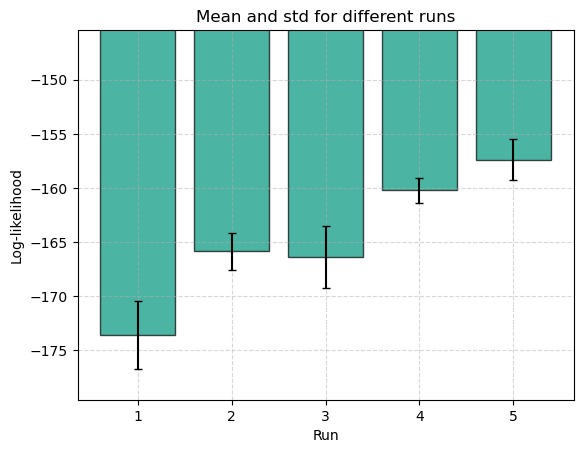

In [14]:
list_means = []
list_std = []
for likelihoods in list_l:
    last_epoch_l = np.array(likelihoods[-n_last_likelihoods:])
    list_means.append(last_epoch_l.mean())
    list_std.append(last_epoch_l.std())

color = "#4fabbc"
plot_likelihood_means(np.arange(1,len(list_means)+1), list_means, yerr=list_std, title="Mean and std for different runs", xlabel="Run")

The image shows the final log-likelihoods of the five runs alongside their standard deviation. The points are the mean of the log-likelihood evaluated in the last epochs in the training phase.

## 2.2) Does the Log-Likelihood depend on the number of CD steps?

In [17]:
n_last_likelihoods = 6
steps = 6

In [18]:
'''for n in range(1,4):
    print(f"CD_steps: {n}")
    rbm = RBM(X_keep, 10, spins=False, potts=False)
    rbm.initialize_params()
    rbm.training(epochs=150, optimizer="RMSprop", cd_steps=n, verbose=True)
    rbm.likelihood_history(12, n_last_likelihoods, steps)
    save_model(rbm, f"DATA/10L_150e_RMS_cd{n}")'''

'for n in range(1,4):\n    print(f"CD_steps: {n}")\n    rbm = RBM(X_keep, 10, spins=False, potts=False)\n    rbm.initialize_params()\n    rbm.training(epochs=150, optimizer="RMSprop", cd_steps=n, verbose=True)\n    rbm.likelihood_history(12, n_last_likelihoods, steps)\n    save_model(rbm, f"DATA/10L_150e_RMS_cd{n}")'

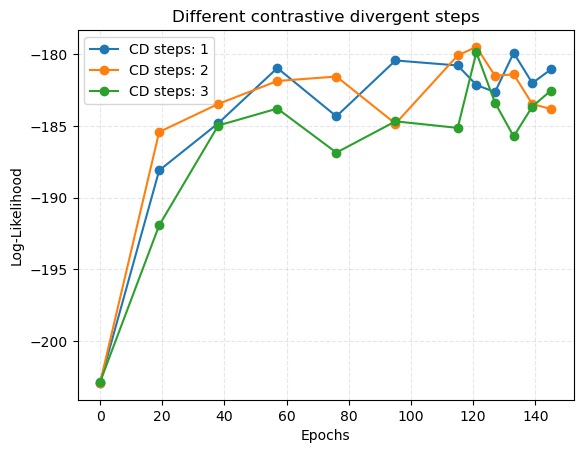

In [19]:
list_models = [load_model(f"DATA/3L_150e_RMS_cd{n}") for n in range(1,4)]
list_e = list_models[0].log_likelihood.esit_ix
list_l = [model.log_likelihood.esit for model in list_models]

labels = [f"CD steps: {i+1}" for i in range(len(list_l))]
cmap = cm.RdPu
colors = [cmap(i) for i in np.linspace(0.2,0.8,len(list_models))]

plot_likelihood_evolutions(list_e, list_l, list_labels=labels, title="Different contrastive divergent steps")

The figure illustrates the growth of the log-likelihood during the training phase for different numbers of Contrastive Divergence steps, from 1 to 3.

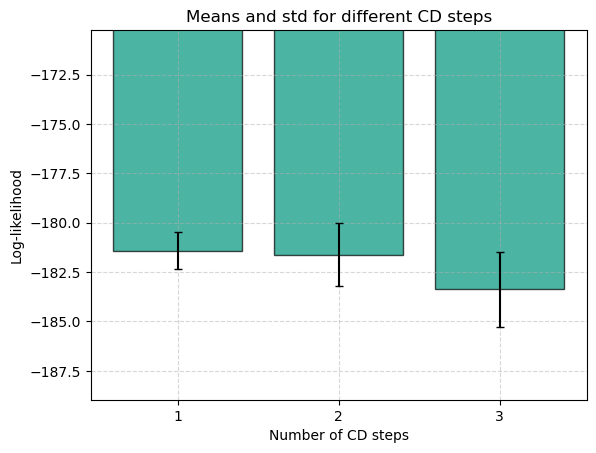

In [21]:
list_means = []
list_std = []
for likelihoods in list_l:
    last_epoch_l = np.array(likelihoods[-n_last_likelihoods:])
    list_means.append(last_epoch_l.mean())
    list_std.append(last_epoch_l.std())

plot_likelihood_means(range(1,4), list_means, yerr=list_std, xlabel="Number of CD steps", title="Means and std for different CD steps")

In this graph we can see that the number of CD steps does not affect the final log-likelihood, meaning that the values are compatible.

## 2.3) Compare the Log-Likelihood for different L

In [24]:
list_L = list(range(3,14))
n_last_likelihoods = 6
steps = 6

In [25]:
'''for L in list_L:
    np.random.seed(42)
    print(f"L: {L} (of 13)")
    
    rbm = RBM(X_keep, L, spins=False, potts=False)
    rbm.initialize_params()
    rbm.training(epochs=150, optimizer="RMSprop", verbose=True)
    rbm.likelihood_history(12, n_last_likelihoods, steps)
    save_model(rbm, f"DATA/{L}L_150e_RMS_comparisonL")'''

'for L in list_L:\n    np.random.seed(42)\n    print(f"L: {L} (of 13)")\n    \n    rbm = RBM(X_keep, L, spins=False, potts=False)\n    rbm.initialize_params()\n    rbm.training(epochs=150, optimizer="RMSprop", verbose=True)\n    rbm.likelihood_history(12, n_last_likelihoods, steps)\n    save_model(rbm, f"DATA/{L}L_150e_RMS_comparisonL")'

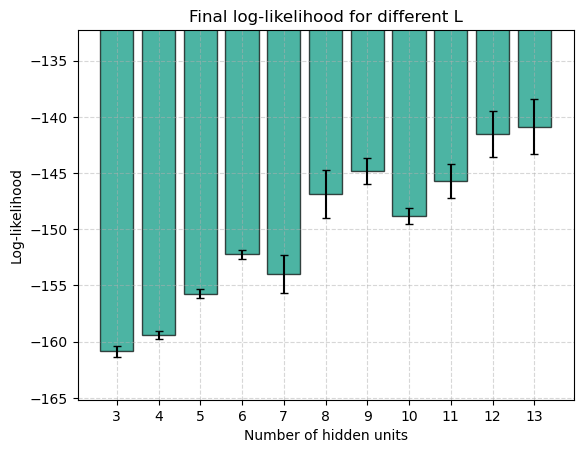

In [26]:
list_models = [load_model(f"DATA/{L}L_150e_RMS_comparisonL") for L in list_L]
list_e = list_models[0].log_likelihood.esit_ix
list_l = [model.log_likelihood.esit for model in list_models]
labels = [f"L = {L}" for L in list_L]

list_means = []
list_std = []
for likelihoods in list_l:
    last_epoch_l = np.array(likelihoods[-n_last_likelihoods:])
    list_means.append(last_epoch_l.mean())
    list_std.append(last_epoch_l.std())

plot_likelihood_means(list_L, list_means, yerr=list_std, xlabel="Number of hidden units", title="Final log-likelihood for different L")

The figure presents the value of the final log-likelihood for different values of the hidden units L of the RBM. L = 10 seems to be the number that performs best. Due to stochasticity, in order to minimize the number of variable parameters, we chose the same initial seed for each L.

# 3) HYPERPARAMETERS

## 3.1) Learning Rate

In [29]:
list_lr = list(range(0,-5,-1))
n_last_likelihoods = 6
steps = 6

In [30]:
'''for i,n in enumerate(list_lr):
    print(f"Learning rate n°{i+1} (of {len(list_lr)})")
    rbm = RBM(X_keep, 6, spins=False, potts=False)
    rbm.initialize_params()
    rbm.training(epochs=150, optimizer="RMSprop", lr=10**n, verbose=True)
    rbm.likelihood_history(12, n_last_likelihoods, steps)
    save_model(rbm, f"DATA/6L_150e_RMS_lr{i+1}")'''

'for i,n in enumerate(list_lr):\n    print(f"Learning rate n°{i+1} (of {len(list_lr)})")\n    rbm = RBM(X_keep, 6, spins=False, potts=False)\n    rbm.initialize_params()\n    rbm.training(epochs=150, optimizer="RMSprop", lr=10**n, verbose=True)\n    rbm.likelihood_history(12, n_last_likelihoods, steps)\n    save_model(rbm, f"DATA/6L_150e_RMS_lr{i+1}")'

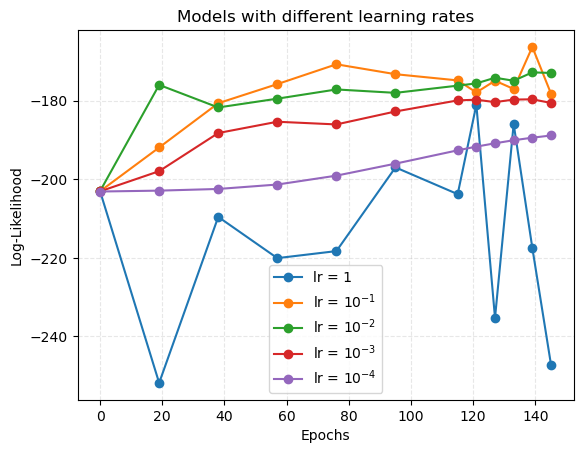

In [31]:
list_models = [load_model(f"DATA/6L_150e_RMS_lr{i+1}") for i in range(len(list_lr))]
list_e = list_models[0].log_likelihood.esit_ix
list_l = [model.log_likelihood.esit for model in list_models]

labels = [f"lr = $10^{{{n}}}$" if n!=0 else "lr = 1" for n in list_lr]
cmap = cm.RdPu
colors = [cmap(i) for i in np.linspace(0.2, 0.8, len(list_models))]

plot_likelihood_evolutions(list_e, list_l, list_labels=labels, title="Models with different learning rates")

The figure illustrates the trend of the log-likelihood during training for different values of the learning rate in the gradient ascent step, using RMSprop as optimizer. For lower learning rate values the best ascending trend is observed.

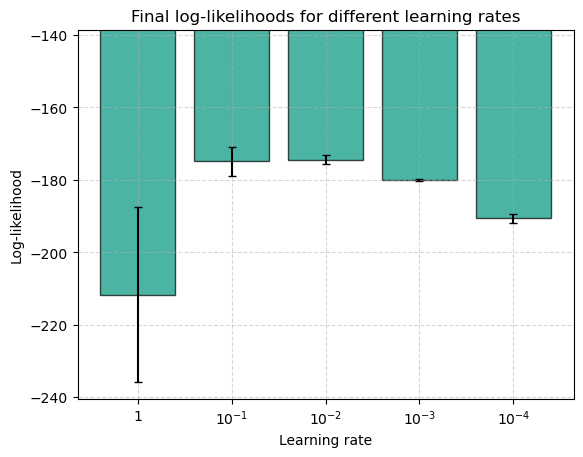

In [33]:
list_means = []
list_std = []
for likelihoods in list_l:
    last_epoch_l = np.array(likelihoods[-n_last_likelihoods:])
    list_means.append(last_epoch_l.mean())
    list_std.append(last_epoch_l.std())

x_labels = [f"$10^{{{n}}}$" if n!=0 else "$1$" for n in list_lr]
plot_likelihood_means(x_labels, list_means, yerr=list_std, xlabel="Learning rate", rate_delta=0.2, title="Final log-likelihoods for different learning rates")

The figure shows the final log-likelihood for different values of the learning rate. For an intermediate learning rate the log-likelihood is maximized with the lowest standard deviation.

## 3.2) Epsilon

In [36]:
list_epsilon = list(range(-9,-3))
n_last_likelihoods = 6
steps = 6

In [37]:
'''for i,n in enumerate(list_epsilon):
    print(f"Epsilon n° {i+1} (of {len(list_epsilon)}):")
    rbm = RBM(X_keep, 6, spins=False, potts=False)
    rbm.initialize_params()
    rbm.training(epochs=150, optimizer="RMSprop", epsilon=10**n, verbose=True)
    rbm.likelihood_history(12, n_last_likelihoods, steps)
    save_model(rbm, f"DATA/6L_150e_RMS_epsilon{i+1}")'''

'for i,n in enumerate(list_epsilon):\n    print(f"Epsilon n° {i+1} (of {len(list_epsilon)}):")\n    rbm = RBM(X_keep, 6, spins=False, potts=False)\n    rbm.initialize_params()\n    rbm.training(epochs=150, optimizer="RMSprop", epsilon=10**n, verbose=True)\n    rbm.likelihood_history(12, n_last_likelihoods, steps)\n    save_model(rbm, f"DATA/6L_150e_RMS_epsilon{i+1}")'

<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_7219/3628035550.py:9: SyntaxWarning: invalid escape sequence '\e'
  plot_likelihood_evolutions(list_e, list_l, list_labels=labels, title="Models with different value of $\epsilon$")


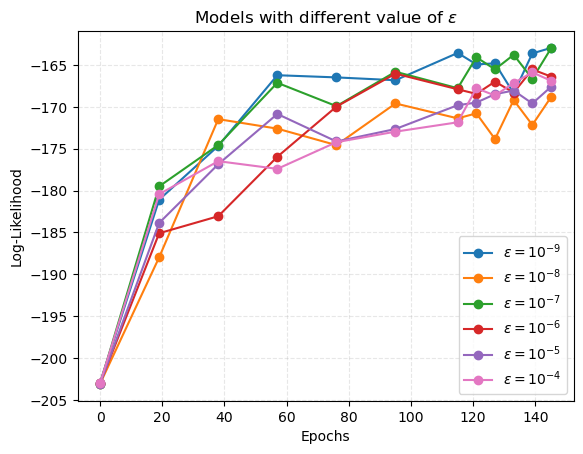

In [38]:
list_models = [load_model(f"DATA/6L_150e_RMS_epsilon{i+1}") for i in range(len(list_epsilon))]
list_e = list_models[0].log_likelihood.esit_ix
list_l = [model.log_likelihood.esit for model in list_models]

labels = [rf"$\epsilon = 10^{{{n}}}$" for n in list_epsilon]
cmap = cm.RdPu
colors = [cmap(i) for i in np.linspace(0.2, 0.8, len(list_models))]

plot_likelihood_evolutions(list_e, list_l, list_labels=labels, title="Models with different value of $\epsilon$")

The figure shows the evolution of the log-likelihood during training for different values of the epsilon parameter in the RMSprop gradient descent type. Apart from stochasticity the models tend to follow the same trend.

<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_7219/3139587491.py:9: SyntaxWarning: invalid escape sequence '\e'
  plot_likelihood_means(x_labels, list_means, yerr=list_std, xlabel="Epsilon", title="Final log-likelihoods for different values of $\epsilon$")


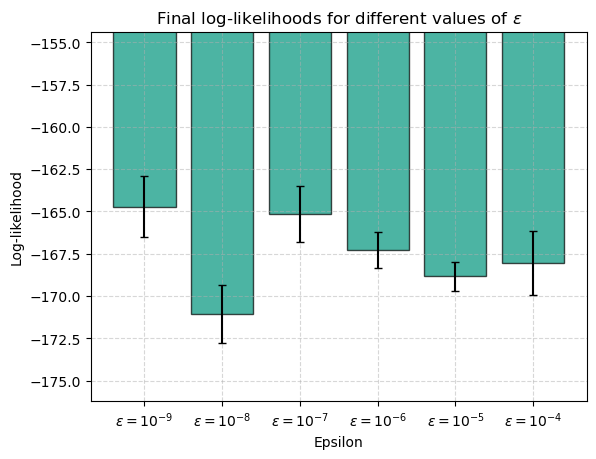

In [40]:
list_means = []
list_std = []
for likelihoods in list_l:
    last_epoch_l = np.array(likelihoods[-n_last_likelihoods:])
    list_means.append(last_epoch_l.mean())
    list_std.append(last_epoch_l.std())

x_labels = [rf"$\epsilon = 10^{{{n}}}$" for n in list_epsilon]
plot_likelihood_means(x_labels, list_means, yerr=list_std, xlabel="Epsilon", title="Final log-likelihoods for different values of $\epsilon$")

The most stable log-likelihoods are obtained for higher values of epsilon, unlike the lower ones. The values are spread in an interval around $-168$.

## 3.3) Optimizers

In [43]:
L = 10
epochs = 150
n_likelihoods = 12
n_last_likelihoods = 6
steps = 6
optimizers = ["RMSprop", "SGD"]
lr = 0.05
epsilon = 1e-8

In [44]:
'''for optimizer in optimizers:
    print(f"Optimizer: {optimizer}")
    rbm = RBM(X_keep, L)
    rbm.initialize_params()
    rbm.training(epochs=epochs, optimizer=optimizer, verbose=True)
    rbm.likelihood_history(n_likelihoods, n_last_likelihoods, steps)
    save_model(rbm, f"DATA/{L}L_{epochs}e_{optimizer}_optimizer")'''

'for optimizer in optimizers:\n    print(f"Optimizer: {optimizer}")\n    rbm = RBM(X_keep, L)\n    rbm.initialize_params()\n    rbm.training(epochs=epochs, optimizer=optimizer, verbose=True)\n    rbm.likelihood_history(n_likelihoods, n_last_likelihoods, steps)\n    save_model(rbm, f"DATA/{L}L_{epochs}e_{optimizer}_optimizer")'

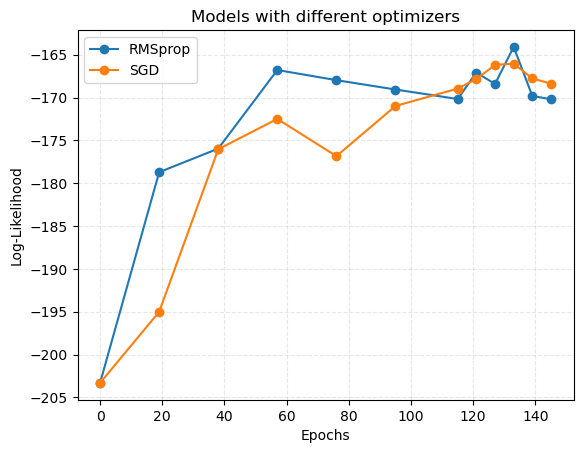

In [45]:
list_models = [load_model(f"DATA/{L}L_{epochs}e_{opt}_optimizer") for opt in optimizers]
list_e = list_models[0].log_likelihood.esit_ix
list_l = [model.log_likelihood.esit for model in list_models]

cmap = cm.RdPu
colors = [cmap(i) for i in np.linspace(0.2, 0.8, len(list_models))]

plot_likelihood_evolutions(list_e, list_l, list_labels=optimizers, title="Models with different optimizers")

In this figure we notice that both of the optimizers perform almost the same.

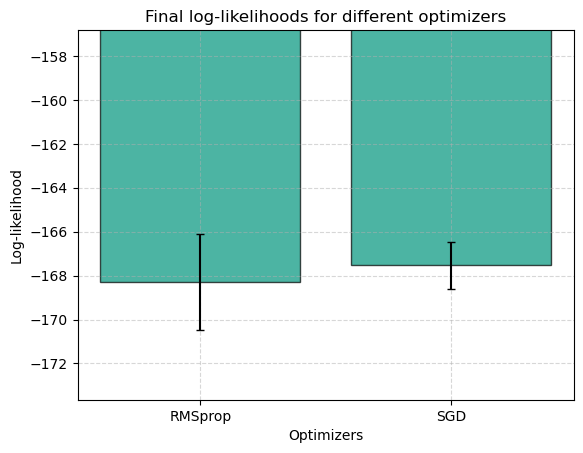

In [47]:
list_means = []
list_std = []
for likelihoods in list_l:
    last_epoch_l = np.array(likelihoods[-n_last_likelihoods:])
    list_means.append(last_epoch_l.mean())
    list_std.append(last_epoch_l.std())

plot_likelihood_means(optimizers, list_means, yerr=list_std, xlabel="Optimizers", title="Final log-likelihoods for different optimizers")

In this graph we can see that the final log-likelihoods are compatible for both optimizers.

## 3.4) Gamma

In [50]:
gamma_values = [f"10**{n}" if n != 0 else "0" for n in range(-5,1)]
n_last_likelihoods = 6
steps = 6

In [51]:
'''for i,gamma in enumerate(gamma_values):
    print(f"Gamma n° {i+1} (of {len(gamma_values)})")
    rbm = RBM(X_keep, 6)
    rbm.initialize_params()
    rbm.training(epochs=150, optimizer="RMSprop", gamma=eval(gamma), verbose=True)
    rbm.likelihood_history(12, n_last_likelihoods, steps)
    save_model(rbm, f"DATA/6L_150e_RMS_gamma{i+1}")'''

'for i,gamma in enumerate(gamma_values):\n    print(f"Gamma n° {i+1} (of {len(gamma_values)})")\n    rbm = RBM(X_keep, 6)\n    rbm.initialize_params()\n    rbm.training(epochs=150, optimizer="RMSprop", gamma=eval(gamma), verbose=True)\n    rbm.likelihood_history(12, n_last_likelihoods, steps)\n    save_model(rbm, f"DATA/6L_150e_RMS_gamma{i+1}")'

<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_7219/4229818992.py:9: SyntaxWarning: invalid escape sequence '\g'
  plot_likelihood_evolutions(list_e, list_l, list_labels=labels, title="Models with different $\gamma$ values")


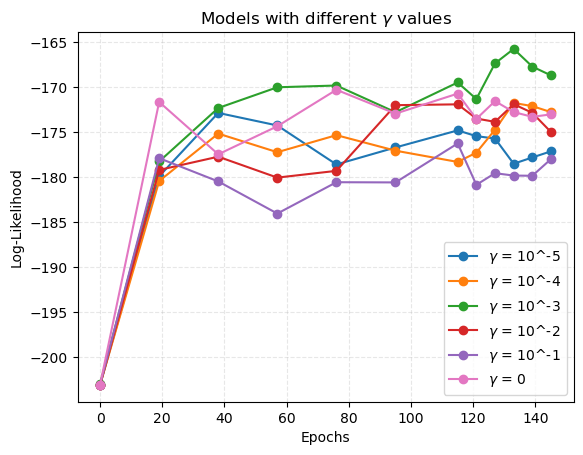

In [52]:
list_models = [load_model(f"DATA/6L_150e_RMS_gamma{i+1}") for i in range(len(gamma_values))]
list_e = list_models[0].log_likelihood.esit_ix
list_l = [model.log_likelihood.esit for model in list_models]

labels = [rf"$\gamma$ = {gamma_values[i].replace('**', '^')}" for i in range(len(list_l))]
cmap = cm.RdPu
colors = [cmap(i) for i in np.linspace(0.2, 0.8, len(list_models))]

plot_likelihood_evolutions(list_e, list_l, list_labels=labels, title="Models with different $\gamma$ values")

The image illustrates the evolution of the log-likelihood during training for different values of the gamma parameter, involved in the regularization step. Around 20 epochs the trend tends to stabilize.

<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_7219/2138767781.py:9: SyntaxWarning: invalid escape sequence '\g'
  plot_likelihood_means(xticks, list_means, yerr=list_std, xlabel="Gamma values", title="Final log-likelihoods for different $\gamma$")


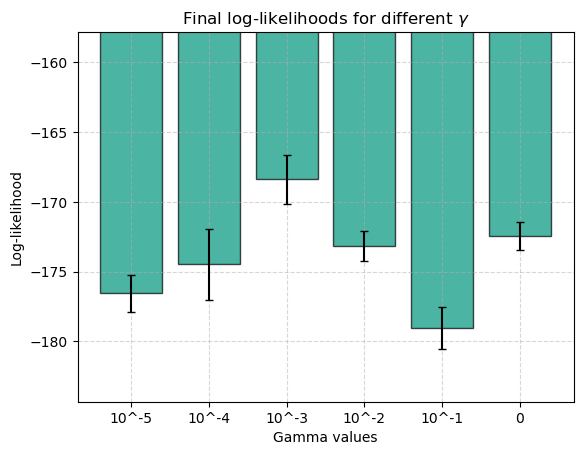

In [54]:
list_means = []
list_std = []
for likelihoods in list_l:
    last_epoch_l = np.array(likelihoods[-n_last_likelihoods:])
    list_means.append(last_epoch_l.mean())
    list_std.append(last_epoch_l.std())

xticks = [rf"{gamma_values[i].replace('**', '^')}" for i in range(len(list_l))]
plot_likelihood_means(xticks, list_means, yerr=list_std, xlabel="Gamma values", title="Final log-likelihoods for different $\gamma$")

The $\gamma$ value that gives the best performance is $10^{-3}$.

## 3.5) POTTS

In [57]:
L = 10
epochs = 150
n_likelihoods = 12
n_last_likelihoods = 6
steps = 6
lr = 1e-2
epsilon = 1e-8
gamma = 1e-4
optimizers = ["RMSprop", "SGD"]
spins_potts = [(False, False), (True, False), (False, True)]

In [58]:
'''for i,optimizer in enumerate(optimizers):
    for j,(spins, potts) in enumerate(spins_potts):
        print(f"Optimizer {optimizer}, spins={spins}, potts={potts} ({i*len(optimizers)+j} of {len(optimizers)*len(spins_potts)})")
        rbm = RBM(X_keep, L, spins=spins, potts=potts)
        rbm.initialize_params()
        rbm.training(epochs=epochs, optimizer=optimizer, verbose=True)
        rbm.likelihood_history(n_likelihoods, n_last_likelihoods, steps)
        save_model(rbm, f"DATA/{L}L_{epochs}e_{optimizer}_s{spins}_p{potts}")'''

'for i,optimizer in enumerate(optimizers):\n    for j,(spins, potts) in enumerate(spins_potts):\n        print(f"Optimizer {optimizer}, spins={spins}, potts={potts} ({i*len(optimizers)+j} of {len(optimizers)*len(spins_potts)})")\n        rbm = RBM(X_keep, L, spins=spins, potts=potts)\n        rbm.initialize_params()\n        rbm.training(epochs=epochs, optimizer=optimizer, verbose=True)\n        rbm.likelihood_history(n_likelihoods, n_last_likelihoods, steps)\n        save_model(rbm, f"DATA/{L}L_{epochs}e_{optimizer}_s{spins}_p{potts}")'

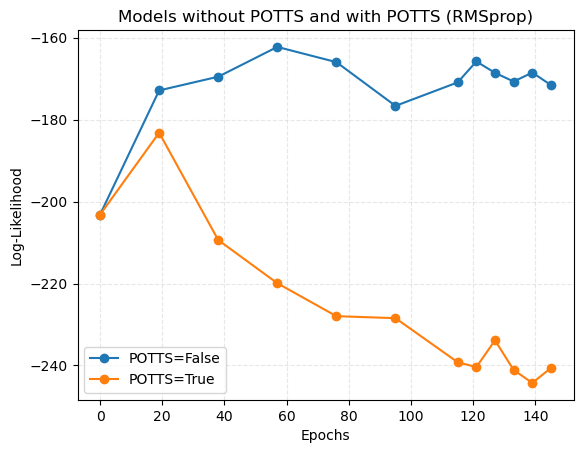

In [59]:
# RMS
list_models = []
for (spins, potts) in [(False, False), (False, True)]:
    list_models.append(load_model(f"DATA/{L}L_{epochs}e_RMSprop_s{spins}_p{potts}"))
list_e = list_models[0].log_likelihood.esit_ix
list_l = [model.log_likelihood.esit for model in list_models]

labels = ["POTTS=False", "POTTS=True"]
cmap = cm.RdPu
colors = [cmap(i) for i in np.linspace(0.2, 0.8, len(list_models))]

plot_likelihood_evolutions(list_e, list_l, list_labels=labels, title="Models without POTTS and with POTTS (RMSprop)")

The graph shows the trend of the log-likelihood during the training phase using RMSprop as optimizer setting the one-hot encoding on (POTTS=True) or off for the hidden units. The model with one-hot encoding does not show any learning trend.

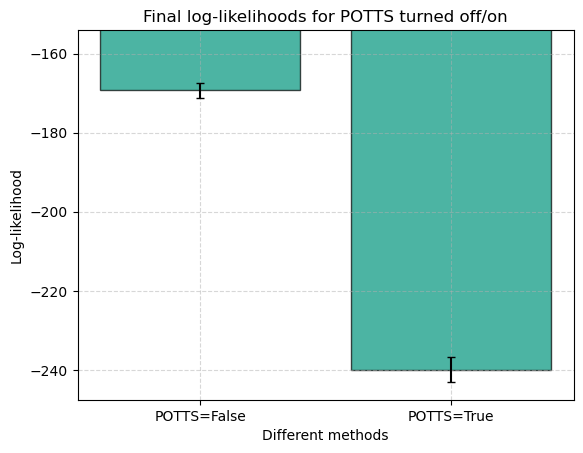

In [61]:
list_means = []
list_std = []
for likelihoods in list_l:
    last_epoch_l = np.array(likelihoods[-n_last_likelihoods:])
    list_means.append(last_epoch_l.mean())
    list_std.append(last_epoch_l.std())

plot_likelihood_means(labels, list_means, yerr=list_std, xlabel="Different methods", title="Final log-likelihoods for POTTS turned off/on")

As it was shown in the last graph, if POTTS=True the model performs much worse than the other one.

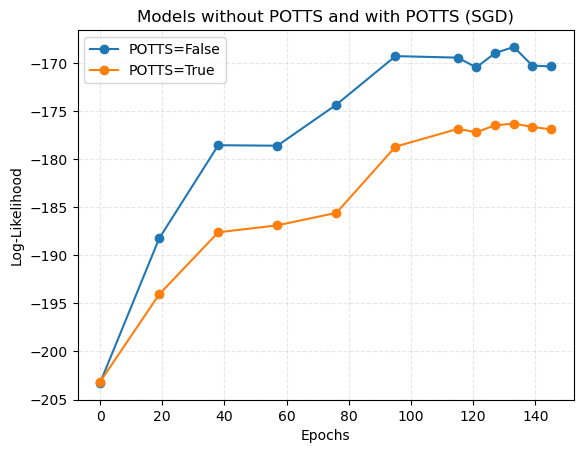

In [63]:
# SGD
list_models = []
for (spins, potts) in [(False, False), (False, True)]:
    list_models.append(load_model(f"DATA/{L}L_{epochs}e_SGD_s{spins}_p{potts}"))
list_e = list_models[0].log_likelihood.esit_ix
list_l = [model.log_likelihood.esit for model in list_models]

labels = ["POTTS=False", "POTTS=True"]
cmap = cm.RdPu
colors = [cmap(i) for i in np.linspace(0.2, 0.8, len(list_models))]

plot_likelihood_evolutions(list_e, list_l, list_labels=labels, title="Models without POTTS and with POTTS (SGD)")

The graph shows the trend of the log-likelihood during the training phase using SGD as optimizer setting the one-hot encoding on (POTTS=True) or off for the hidden units. In this case, the model with one-hot encoding is learning even though it always performs worse than the other model.

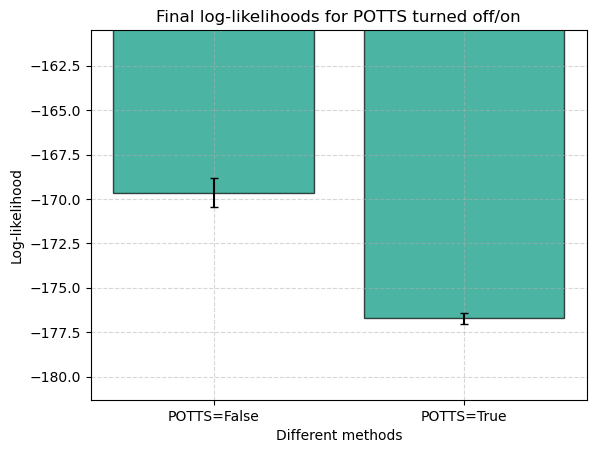

In [65]:
list_means = []
list_std = []
for likelihoods in list_l:
    last_epoch_l = np.array(likelihoods[-n_last_likelihoods:])
    list_means.append(last_epoch_l.mean())
    list_std.append(last_epoch_l.std())

plot_likelihood_means(labels, list_means, yerr=list_std, xlabel="Different methods", title="Final log-likelihoods for POTTS turned off/on")

As it was shown in the last graph, if POTTS=True the model performs worse than the other one.

## 3.6) Spins = True

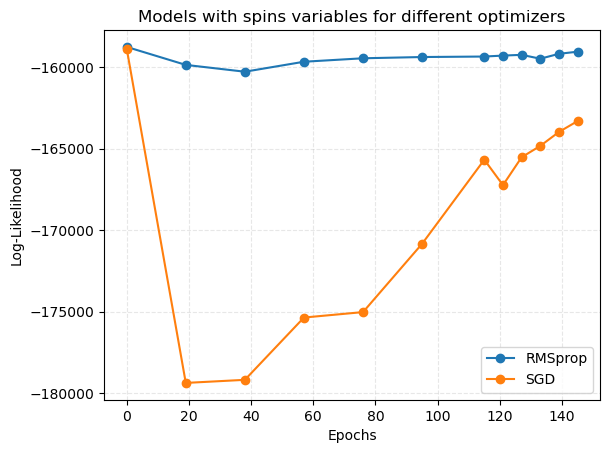

In [68]:
list_models = []
for optimizer in optimizers:
    list_models.append(load_model(f"DATA/{L}L_{epochs}e_{optimizer}_sTrue_pFalse"))
list_e = list_models[0].log_likelihood.esit_ix
list_l = [model.log_likelihood.esit for model in list_models]

labels = ["RMSprop", "SGD"]
cmap = cm.RdPu
colors = [cmap(i) for i in np.linspace(0.2, 0.8, len(list_models))]

plot_likelihood_evolutions(list_e, list_l, list_labels=labels, title="Models with spins variables for different optimizers")

In here we notice that both the optimizers with spin variables perform way worse than the other cases. Using RMSprop the log-likelihood remains almost the same, but SGD lacks a clear trend.

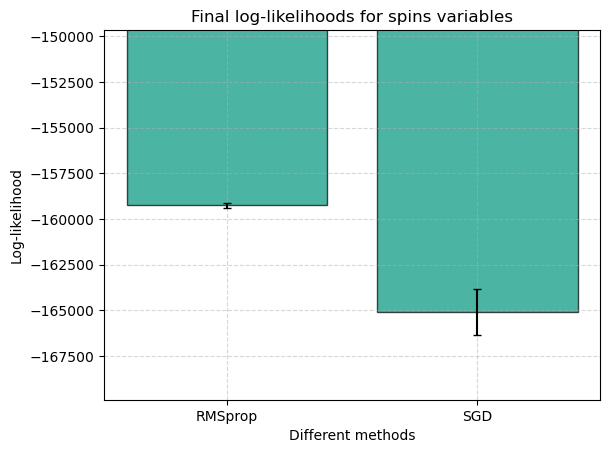

In [70]:
list_means = []
list_std = []
for likelihoods in list_l:
    last_epoch_l = np.array(likelihoods[-n_last_likelihoods:])
    list_means.append(last_epoch_l.mean())
    list_std.append(last_epoch_l.std())

plot_likelihood_means(labels, list_means, yerr=list_std, xlabel="Different methods", title="Final log-likelihoods for spins variables")

Both of the models give a bad performance, but RMSprop reaches higher values.

## 3.7) Different dataset

In [73]:
n_last_likelihoods = 6
steps = 6

In [74]:
'''for n in range(3, 10):
    index_to_keep = np.isin(Y, [str(n1) for n1 in range(n-2,n+1)])
    X_keep = X[index_to_keep]
    print(f"Digits: {[str(n1) for n1 in range(n-2,n+1)]}")
    
    rbm = RBM(X_keep, 10, spins=False, potts=False)
    rbm.initialize_params()
    rbm.training(epochs=150, optimizer="RMSprop", verbose=True)
    rbm.likelihood_history(12, n_last_likelihoods, steps)
    save_model(rbm, f"DATA/10L_150e_RMS_{n-2}{n-1}{n}digits")'''

'for n in range(3, 10):\n    index_to_keep = np.isin(Y, [str(n1) for n1 in range(n-2,n+1)])\n    X_keep = X[index_to_keep]\n    print(f"Digits: {[str(n1) for n1 in range(n-2,n+1)]}")\n    \n    rbm = RBM(X_keep, 10, spins=False, potts=False)\n    rbm.initialize_params()\n    rbm.training(epochs=150, optimizer="RMSprop", verbose=True)\n    rbm.likelihood_history(12, n_last_likelihoods, steps)\n    save_model(rbm, f"DATA/10L_150e_RMS_{n-2}{n-1}{n}digits")'

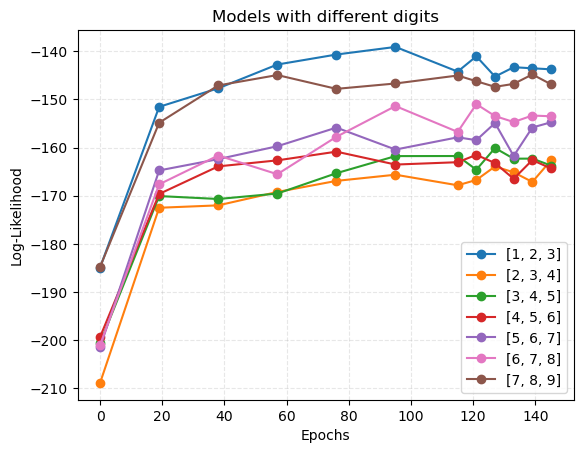

In [122]:
list_models = []
for n in range(3, 10):
    list_models.append(load_model(f"DATA/10L_150e_RMS_{n-2}{n-1}{n}digits"))
list_e = list_models[0].log_likelihood.esit_ix
list_l = [model.log_likelihood.esit for model in list_models]

labels = [str([n1 for n1 in range(n-2,n+1)]) for n in range(3,10)]
cmap = cm.RdPu
colors = [cmap(i) for i in np.linspace(0.2, 0.8, len(list_models))]

plot_likelihood_evolutions(list_e, list_l, list_labels=labels, title = "Models with different digits")

This graph shows how models with different digits perform. Indipendenlty on the initialization the models show very similar trends.

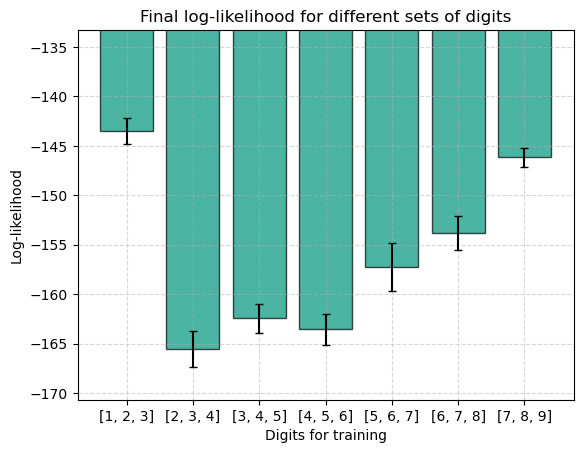

In [126]:
list_means = []
list_std = []
for likelihoods in list_l:
    last_epoch_l = np.array(likelihoods[-n_last_likelihoods:])
    list_means.append(last_epoch_l.mean())
    list_std.append(last_epoch_l.std())

plot_likelihood_means(labels, list_means, yerr=list_std, xlabel="Digits for training", title = "Final log-likelihood for different sets of digits")

Here we can see how the RBM perform best with $[1,2,3]$ as the set of digits. 